In [1]:
import random
from deap import base, creator, tools, algorithms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import time
import copy

# Entradas diretas a partir do arquivo Excel carregado previamente
PRODUTOS = ['p1', 'p2', 'p3', 'p4', 'p5', 'p6']  # Lista de produtos
FABRICAS = ['f1', 'f2', 'f3', 'f4']  # Lista de fábricas
CD = 'f5'  # O CD foi renomeado para 'CD' para maior clareza
# Dados da demanda no CD por produto
demanda_cd_data = {
    "Produto": ["p1", "p2", "p3", "p4", "p5", "p6"],
    "Quantidade (ton)": [420, 200, 300, 200, 130, 380]
}
demanda_cd_df = pd.DataFrame(demanda_cd_data)
DEMAND = demanda_cd_df['Quantidade (ton)'].tolist()

# Estoque inicial no CD por produto
estoque_cd_data = {
    "Produto": ["p1", "p2", "p3", "p4", "p5", "p6"],
    "Quantidade (ton)": [80, 21.42, 50, 40, 16, 20]
}
estoque_cd_df = pd.DataFrame(estoque_cd_data)
INITIAL_STOCK_CD = estoque_cd_df['Quantidade (ton)'].tolist()
estoque_cd = list(INITIAL_STOCK_CD)

# Estoque inicial nas fábricas por produto e por fábrica
estoque_fabricas_data = {
    "Produto": ["p1", "p2", "p3", "p4", "p5", "p6"],
    "f1": [80, 21.42, 50, 0.00, 0.00, 0.00],
    "f2": [0.00, 0.00, 0.00, 0.00, 16, 0.00],
    "f3": [80, 21.42, 0.00, 0.00, 0.00, 0.00],
    "f4": [0.00, 0.00, 50, 40, 0.00, 20]
}
estoque_fabricas_df = pd.DataFrame(estoque_fabricas_data)
INITIAL_STOCK_FACTORIES = estoque_fabricas_df.iloc[:, 1:].values
estoque_fabricas = INITIAL_STOCK_FACTORIES.copy()
# Capacidade de produção por fábrica por produto
capacidade_producao_data = {
    "Produto": ["p1", "p2", "p3", "p4", "p5", "p6"],
    "f1": [80.00, 21.42, 50, 0.00, 0.00, 0.00],
    "f2": [0.00, 0.00, 0.00, 0.00, 16.00, 0.00],
    "f3": [80.00, 21.42, 0.00, 0.00, 0.00, 0.00],
    "f4": [0.00, 0.00, 50, 40.00, 0.00, 20.00]
}
capacidade_producao_df = pd.DataFrame(capacidade_producao_data)
PRODUCTION_CAPACITY = capacidade_producao_df.iloc[:, 1:].values

# Dados fornecidos com a identificação dos veículos
capacidade_transporte_data = {
    "veículo": ["t1-k1", "t1-k2", "t1-k3", "t2-k1", "t2-k2", "t1-k1", "t1-k2", "t1-k3", "t2-k1", "t2-k2",
                "t1-k1", "t1-k2", "t1-k3", "t2-k1", "t2-k2", "t1-k1", "t1-k2", "t1-k3", "t2-k1", "t2-k2",
               "t1-k1", "t1-k2", "t1-k3", "t2-k1", "t2-k2", "t3-k1", "t3-k2", "t3-k3", "t3-k4", "t3-k5",
                "t4-k1", "t4-k2", "t4-k3", "t4-k4", "t4-k1", "t4-k2", "t4-k3", "t4-k4", "t4-k1", "t4-k2",
                "t4-k3", "t4-k4"],
    "fábrica": ["f1", "f1", "f1", "f1", "f1", "f3", "f3", "f3", "f3", "f3",
                "f1", "f1", "f1", "f1", "f1", "f3", "f3", "f3", "f3", "f3",
                "f2", "f2", "f2", "f2", "f2", "f1", "f1", "f1", "f1", "f1",
                "f4", "f4", "f4", "f4", "f4", "f4", "f4", "f4", "f4", "f4",
                "f4", "f4"],
    "produto": ["p1", "p1", "p1", "p1", "p1", "p1", "p1", "p1", "p1", "p1",
                "p2", "p2", "p2", "p2", "p2", "p2", "p2", "p2", "p2", "p2",
                "p5", "p5", "p5", "p5", "p5", "p3", "p3", "p3", "p3", "p3",
                "p3", "p3", "p3", "p3", "p4", "p4", "p4", "p4", "p6", "p6",
                "p6", "p6"],
    "capacidade": [21.168, 21.168, 21.168, 12.096, 12.096, 21.168, 21.168, 21.168, 12.096, 12.096,
                   22.680, 22.680, 22.680, 12.960, 12.960, 22.680, 22.680, 22.680, 12.960, 12.960,
                   17.2032, 17.2032, 17.2032, 9.8304, 9.8304, 25, 25, 25, 25, 25, 50, 50,
                   50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
}
# Criar DataFrame com as informações dos veículos
veiculos_transporte_df = pd.DataFrame(capacidade_transporte_data)

# Remover duplicatas agregando capacidades por soma
capacidade_transporte_df = veiculos_transporte_df.groupby(["produto", "fábrica"], as_index=False)["capacidade"].sum()

# Realizar o pivot para obter a matriz de capacidades de transporte
CAPACIDADE_TRANSPORTE = capacidade_transporte_df.pivot(index="produto", columns="fábrica", values="capacidade").fillna(0).to_numpy()

# Agrupar as capacidades de transporte apenas por produto e somar as capacidades, independentemente da fábrica
capacidade_total_produto_df = veiculos_transporte_df.groupby("produto", as_index=False)["capacidade"].sum()

# Dias de quarentena por produto
quarentena_data = {
    "Produto": ["p1", "p2", "p3", "p4", "p5", "p6"],
    "Dias de Quarentena": [20, 0, 3, 0, 5, 2]
}
quarentena_df = pd.DataFrame(quarentena_data)
QUARANTINE_DAYS = quarentena_df['Dias de Quarentena'].tolist()

# Aqui estamos associando os produtos às fábricas corretas
origem_produto = ['f1', 'f3', 'f3', 'f1', 'f1', 'f4', 'f2', 'f1', 'f2', 'f3', 'f4', 'CD']
destino_produto = ['f3', 'f1', 'CD', 'CD', 'f4', 'CD', 'CD', 'f1', 'f2', 'f3', 'f4', 'CD']

transporte_data = {
    "Origem": ["f1", "f3", "f3", "f1", "f1", "f4", "f2", "f1", "f2", "f3", "f4", "f5"],
    "Destino": ["f3", "f1", "f5", "f5", "f4", "f5", "f5", "f1", "f2", "f3", "f4", "f5"],
    "Tempo (dias)": [1, 1, 2, 2, 2, 1, 2, 0, 0, 0, 0, 0]
}
transporte_df = pd.DataFrame(transporte_data)

# Criar o dicionário de tempo de transporte
TRANSPORTE = {f"{row['Origem']}-{row['Destino']}": row['Tempo (dias)'] 
              for _, row in transporte_df.iterrows()}

In [2]:
# Parâmetros do Problema
NUM_PRODUCTS = len(DEMAND)
NUM_FACTORIES = PRODUCTION_CAPACITY.shape[1]
NUM_PERIODS = 30

# Criar Classe de Fitness para minimizar Tmax
if "FitnessMin" not in dir(creator):
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
if "Individual" not in dir(creator):
    creator.create("Individual", list, fitness=creator.FitnessMin)
# Alteração na criação do indivíduo para incluir o atributo phases
if "IndividualWithPhases" not in dir(creator):
    creator.create("IndividualWithPhases", creator.Individual, phases=None)  # Adicionando o atributo 'phases'

toolbox = base.Toolbox()
toolbox.register("attr_int", random.randint, 1, NUM_PERIODS) # Mais flexibilidade
toolbox.register("individual", tools.initRepeat, creator.IndividualWithPhases, toolbox.attr_int, n=NUM_PRODUCTS)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

precedences = {1: 0, 3: 2} # Onde P2 (índice 1) depende de P1 (índice 0), e P4 (índice 3) depende de P3 (índice 2)

In [3]:
def calculate_transport_time_phases(origem, destino, ultimos_dias, produto_especifico):
    # Acessar diretamente a capacidade do produto específico
    row = capacidade_total_produto_df[capacidade_total_produto_df["produto"] == produto_especifico].iloc[0]
    capacidade_total_produto = row["capacidade"]
    
    # Usar ultimos_dias_producao diretamente
    if sum(ultimos_dias) <= capacidade_total_produto:  # Condição de capacidade
        tempo_transporte = 3 # (Entrega no dia seguinte no CD)
    else:
        tempo_transporte = 4  # (Entrega no dia seguinte no CD)
    
    # Retornar o tempo de transporte calculado
    return tempo_transporte

In [4]:
def calculate_production_duration(demanda_produto, capacidade_producao_produto):
    total_dias_producao = 0
    demanda_restante = demanda_produto
    producao_diaria = []  # Lista para armazenar a produção diária

    while demanda_restante > 0:
        # Produção do dia: para cada fábrica, calcula a produção máxima possível, mas respeita a demanda restante
        producao_diaria_total = sum(min(capacidade_diaria, demanda_restante) for capacidade_diaria in capacidade_producao_produto)
        
        # Reduz a demanda restante pela produção do dia
        demanda_restante -= producao_diaria_total
        producao_diaria.append(producao_diaria_total)  # Adicionar a produção do dia
        total_dias_producao += 1
    total_dias_producao = total_dias_producao - 2
    # Calculando a produção nos últimos dias (últimos 2 dias, se houver)
    ultimos_dias_producao = producao_diaria[-2:] if len(producao_diaria) >= 2 else producao_diaria

    return total_dias_producao, ultimos_dias_producao

# Calculando a produção e a produção nos últimos dias para cada produto
for i, produto in enumerate(PRODUTOS):
    total_dias, ultimos_dias = calculate_production_duration(DEMAND[i], PRODUCTION_CAPACITY[i])

In [5]:
def calculate_phases(individual):
    phases = {
        "start_production": [], "end_production": [],
        "start_quarantine": [], "end_quarantine": [],
        "start_transport": [], "end_transport": [], 
        "total_times": []
    }
    for i, delivery_day in enumerate(individual):
        # Obtendo a duração da produção e os últimos dias de produção
        total_dias_producao, ultimos_dias_producao = calculate_production_duration(DEMAND[i], PRODUCTION_CAPACITY[i])
        
        # Calculando o início da produção
        production_start_day = delivery_day - total_dias_producao - QUARANTINE_DAYS[i] - calculate_transport_time_phases(origem_produto[i], destino_produto[i], ultimos_dias_producao, PRODUTOS[i])
        
        # Calcular quarentena apenas para produtos com QUARANTINE_DAYS > 0
        if i in precedences:
            preced_index = precedences[i]
            # Verificar se o estoque de P1 (produto precedente) já está disponível nas fábricas
            if sum(estoque_fabricas[preced_index]) > 0:  # P1 disponível nas fábricas
                # P2 pode começar imediatamente após a produção de P1 (não precisa esperar quarentena)
                availability_day = random.randint(phases['start_production'][preced_index], phases['end_production'][preced_index])
                production_start_day = availability_day
                production_end_day = production_start_day + total_dias_producao  # Ajustar o final da produção de P2
                # Atualizar transporte do dependente (P2) para iniciar após a produção
                if QUARANTINE_DAYS[i] > 0:
                    quarantine_start_day = production_start_day + 1
                    transport_start_day = production_start_day + 1
                    transport_end_day = quarantine_end_day + calculate_transport_time_phases(origem_produto[i], destino_produto[i], ultimos_dias_producao, PRODUTOS[i])
                else:
                    quarantine_start_day = 0
                    quarantine_end_day = 0
                    transport_start_day = production_start_day + 1
                    transport_end_day = production_end_day + calculate_transport_time_phases(origem_produto[i], destino_produto[i], ultimos_dias_producao, PRODUTOS[i])
            else:
                # Caso contrário, P2 deve esperar pela produção de P1 e sua quarentena
                availability_day = phases['start_quarantine'][preced_index] + QUARANTINE_DAYS[i]
                production_start_day = max(production_start_day, availability_day)
                production_end_day = production_start_day + total_dias_producao

                # Atualizar transporte do dependente para iniciar após o antecedente
                if QUARANTINE_DAYS[i] > 0:
                    quarantine_start_day = production_start_day + 1
                    transport_start_day = production_start_day + 1
                    transport_end_day = quarantine_end_day + calculate_transport_time_phases(origem_produto[i], destino_produto[i], ultimos_dias_producao, PRODUTOS[i])
                else:
                    quarantine_start_day = 0
                    quarantine_end_day = 0
                    transport_start_day = production_end_day + 1
                    transport_end_day = production_end_day + calculate_transport_time_phases(origem_produto[i], destino_produto[i], ultimos_dias_producao, PRODUTOS[i])
        else:
            # Calcular a duração da produção
            production_end_day = production_start_day + total_dias_producao - 2
            if QUARANTINE_DAYS[i] > 0:
                quarantine_start_day = production_start_day + 1
                production_end_day = production_start_day + total_dias_producao
                quarantine_end_day = production_end_day + QUARANTINE_DAYS[i]
                transport_start_day = production_start_day + 1
                transport_end_day = quarantine_end_day + calculate_transport_time_phases(origem_produto[i], destino_produto[i], ultimos_dias_producao, PRODUTOS[i])
            else:
                quarantine_start_day = 0
                quarantine_end_day = 0
                # Calcular transporte
                transport_start_day = production_start_day + 1
                transport_end_day = production_end_day + calculate_transport_time_phases(origem_produto[i], destino_produto[i], ultimos_dias_producao, PRODUTOS[i])
        
        # Armazenar as fases ajustadas
        phases["start_production"].append(production_start_day)
        phases["end_production"].append(production_end_day)
        phases["start_quarantine"].append(quarantine_start_day)
        phases["end_quarantine"].append(quarantine_end_day)
        phases["start_transport"].append(transport_start_day)
        phases["end_transport"].append(transport_end_day)
        phases["total_times"].append(transport_end_day)

    return phases

In [6]:
def repair_individual(individual):
    # Garantir que todos os valores sejam válidos
    for i in range(NUM_PRODUCTS):
        # Atualizar as fases antes de verificar
        individual.phases = calculate_phases(individual)
        # Verificar e corrigir valores inválidos
        if individual[i] <= 0 or individual.phases["start_production"][i] < 1 or individual.phases["start_quarantine"][i] < 0:
            individual[i] = random.randint(1, NUM_PERIODS)  # Substituir com um valor válido
    # Atualizar as fases finais após todas as correções
    individual.phases = calculate_phases(individual)
    return individual

In [7]:
def is_feasible(individual):
    """
    Verifica se o indivíduo é viável com base nas precedências e disponibilidade dos estoques.
    """
    # Calcular as fases de produção, quarentena e transporte para o indivíduo
    individual.phases = calculate_phases(individual)

    # Verificar se a produção começa em um dia inválido
    for i in range(NUM_PRODUCTS):
        if individual.phases["start_production"][i] < 1:
            return False  # Se a produção começar em um dia inválid
        
        if i in precedences:
            preced_index = precedences[i]
            if sum(estoque_fabricas[preced_index]) > 0 and individual.phases["start_quarantine"][preced_index] < 1:
                return False
        
        # Garantir consistência entre fitness e fases
        if (
            individual.fitness.valid and 
            individual.fitness.values and 
            individual.fitness.values[0] != max(individual.phases["total_times"])
        ):
            return False
        Tmax_calculated = max(individual.phases["total_times"])
        if individual.fitness.valid and individual.fitness.values:
            if not math.isclose(individual.fitness.values[0], Tmax_calculated, rel_tol=1e-5):
                print(f"[DEBUG] Fitness armazenado ({individual.fitness.values[0]}) não coincide com Tmax recalculado ({Tmax_calculated}).")
                return False
    return True

In [8]:
def evaluate(individual):
    """Avalia o indivíduo com base no tempo máximo de entrega (Tmax)."""
    if not is_feasible(individual):
        return 60,  # Penalidade alta para indivíduos inviáveis

    # Calcular as fases do indivíduo
    phases = calculate_phases(individual)

    # Atribuir as fases ao indivíduo
    individual.phases = phases  # Garantir que 'phases' seja parte do indivíduo

    Tmax = max(individual.phases["total_times"])
    
    return Tmax,  # Retorna apenas o valor de Tmax

In [9]:
def crossover_and_repair(ind1, ind2):
    tools.cxTwoPoint(ind1, ind2)  # Realiza o crossover
    repair_individual(ind1)       # Repara ind1 in place
    repair_individual(ind2)       # Repara ind2 in place
    return ind1, ind2             # Retorna os indivíduos reparados

In [10]:
# Inicializa a população e aplica o reparo
pop = [repair_individual(ind) for ind in toolbox.population(n=50)]

In [11]:
# Registrando as funções no toolbox
toolbox.register("evaluate", evaluate)
toolbox.register("mate", crossover_and_repair)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.3)  # Mutação com probabilidade de 30%
toolbox.register("select", tools.selTournament, tournsize=3)  # Seleção por torneio

# Estatísticas para monitorar a evolução
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)

# Configurando a Hall of Fame
hof = tools.HallOfFame(1)

# Inicializando o logbook
logbook = tools.Logbook()
logbook.header = ['gen', 'avg', 'min', 'max']

# Lista para armazenar indivíduos de cada geração
individuals_per_generation = []

# Início da medição do tempo
start_time = time.time()

# Executando o AG
NUM_GENERATIONS = 20
CXPB, MUTPB = 0.8, 0.3  # Probabilidades de crossover e mutação
for gen in range(NUM_GENERATIONS):
    offspring = toolbox.select(pop, len(pop))
    offspring = list(map(toolbox.clone, offspring))

    # Aplicar crossover e mutação
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPB:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < MUTPB:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # Avaliar indivíduos com fitness inválido
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # Substituir a população
    pop[:] = offspring
    
    # Atualizar Hall of Fame
    hof.update(pop)

    # Armazenar indivíduos da geração
    individuals_per_generation.append(list(pop))

    # Atualizar as estatísticas
    record = stats.compile(pop)
    logbook.record(gen=gen, **record)
    
    # Calcular Tmax do melhor indivíduo da geração
    best_individual = tools.selBest(pop, 1)[0]
    Tmax = max(best_individual.phases["total_times"])  # Consistência no cálculo de Tmax

# Fim da medição do tempo
end_time = time.time()
execution_time = end_time - start_time

In [12]:
# Plotando a evolução do fitness
def plot_evolution(logbook):
    generations = logbook.select("gen")
    avg_fitness = logbook.select("avg")
    min_fitness = logbook.select("min")
    max_fitness = logbook.select("max")

    plt.figure(figsize=(10, 5))
    plt.plot(generations, avg_fitness, label="Média", marker='o')
    plt.plot(generations, min_fitness, label="Mínimo", marker='o')
    plt.plot(generations, max_fitness, label="Máximo", marker='o')
    plt.xlabel("Gerações")
    plt.ylabel("Fitness")
    plt.title("Evolução do Fitness da População")
    plt.legend()
    plt.grid(True)
    plt.show()

In [13]:
def apresentar_resultados(logbook, pop):
    print("Apresentando resultados finais.")

    # Encontrar o melhor indivíduo (menor Tmax)
    best_individual = tools.selBest(pop, 1)[0]

    # Garantir que as fases estão calculadas
    if not hasattr(best_individual, "phases") or best_individual.phases is None:
        best_individual.phases = calculate_phases(best_individual)

    Tmax_calculated = max(best_individual.phases["total_times"])

    # Verificar consistência do Tmax
    print(f"Tmax armazenado no fitness: {best_individual.fitness.values[0]}")
    print(f"Fases para o melhor indivíduo: {best_individual.phases}")

    if not math.isclose(best_individual.fitness.values[0], Tmax_calculated, rel_tol=1e-5):
        print("[ERRO] Inconsistência detectada no Tmax!")

    print("\nMelhor Indivíduo Encontrado:")
    print(f"Datas de entrega no CD: {best_individual.phases['end_transport']}")
    print(f"Tmax: {Tmax_calculated}")
    print(f"Tempo de execução do algoritmo genético: {execution_time:.2f} segundos")

    # Plotar a evolução do fitness
    plot_evolution(logbook)

Apresentando resultados finais.
Tmax armazenado no fitness: 26.0
Fases para o melhor indivíduo: {'start_production': [1, 2, 12, 12, 5, 3], 'end_production': [2, 5, 13, 15, 12, 20], 'start_quarantine': [2, 0, 13, 0, 6, 4], 'end_quarantine': [22, 0, 16, 0, 17, 22], 'start_transport': [2, 3, 13, 13, 6, 4], 'end_transport': [26, 8, 19, 18, 20, 25], 'total_times': [26, 8, 19, 18, 20, 25]}

Melhor Indivíduo Encontrado:
Datas de entrega no CD: [26, 8, 19, 18, 20, 25]
Tmax: 26
Tempo de execução do algoritmo genético: 25.32 segundos


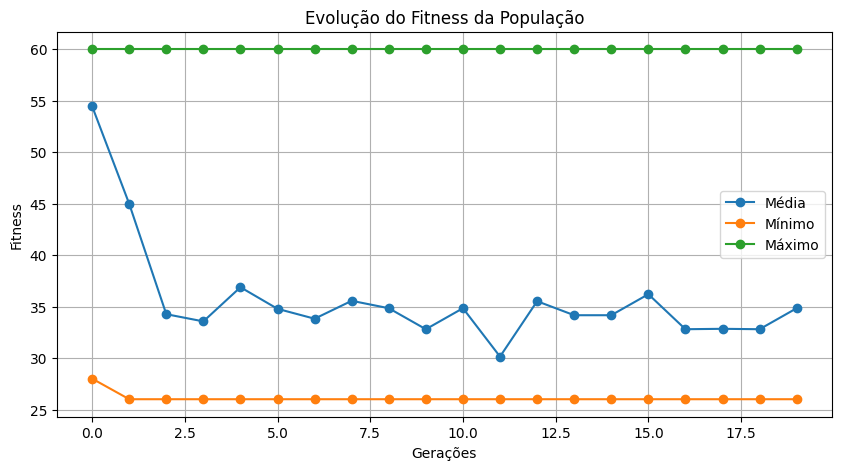

In [14]:
apresentar_resultados(logbook, pop)

In [15]:
import random
import pandas as pd

# Dados de entrada
PRODUTOS = ['p1', 'p2', 'p3', 'p4', 'p5', 'p6']  # Lista de produtos
FABRICAS = ['f1', 'f2', 'f3', 'f4']  # Lista de fábricas
CD = 'f5'  # O CD foi renomeado para 'CD' para maior clareza

# Dados da demanda no CD por produto
demanda_cd_data = {
    "Produto": ["p1", "p2", "p3", "p4", "p5", "p6"],
    "Quantidade (ton)": [420, 200, 300, 200, 130, 380]
}
demanda_cd_df = pd.DataFrame(demanda_cd_data)
DEMAND = demanda_cd_df['Quantidade (ton)'].tolist()

estoque_cd = {'p1': 80, 'p2': 21.42, 'p3': 50, 'p4': 40, 'p5': 16, 'p6': 20}

# Modificando a estrutura do estoque para utilizar nomes de fábricas
estoque_fabricas = {
    'p1': {'f1': 80, 'f2': 0, 'f3': 80, 'f4': 0},  # Produto p1 nas fábricas f1, f2, f3, f4
    'p2': {'f1': 21.42, 'f2': 0, 'f3': 21.42, 'f4': 0},  # Produto p2 nas fábricas
    'p3': {'f1': 50, 'f2': 0, 'f3': 0, 'f4': 50},  # Produto p3 nas fábricas
    'p4': {'f1': 0, 'f2': 0, 'f3': 0, 'f4': 40},  # Produto p4 nas fábricas
    'p5': {'f1': 0, 'f2': 16, 'f3': 0, 'f4': 0},  # Produto p5 nas fábricas
    'p6': {'f1': 0, 'f2': 0, 'f3': 0, 'f4': 20},  # Produto p6 nas fábricas
}

# Capacidade de produção por fábrica por produto
capacidade_producao_data = {
    "Produto": ["p1", "p2", "p3", "p4", "p5", "p6"],
    "f1": [80.00, 21.42, 50, 0.00, 0.00, 0.00],
    "f2": [0.00, 0.00, 0.00, 0.00, 16.00, 0.00],
    "f3": [80.00, 21.42, 0.00, 0.00, 0.00, 0.00],
    "f4": [0.00, 0.00, 50, 40.00, 0.00, 20.00]
}
# Criando o DataFrame com a capacidade de produção
capacidade_producao_df = pd.DataFrame(capacidade_producao_data)

# Definindo 'Produto' como índice
capacidade_producao_df.set_index('Produto', inplace=True)

# Dados fornecidos com a identificação dos veículos
capacidade_transporte_data = {
    "veículo": ["t1-k1", "t1-k2", "t1-k3", "t2-k1", "t2-k2", "t1-k1", "t1-k2", "t1-k3", "t2-k1", "t2-k2",
                "t1-k1", "t1-k2", "t1-k3", "t2-k1", "t2-k2", "t1-k1", "t1-k2", "t1-k3", "t2-k1", "t2-k2",
               "t1-k1", "t1-k2", "t1-k3", "t2-k1", "t2-k2", "t3-k1", "t3-k2", "t3-k3", "t3-k4", "t3-k5",
                "t4-k1", "t4-k2", "t4-k3", "t4-k4", "t4-k1", "t4-k2", "t4-k3", "t4-k4", "t4-k1", "t4-k2",
                "t4-k3", "t4-k4"],
    "fábrica": ["f1", "f1", "f1", "f1", "f1", "f3", "f3", "f3", "f3", "f3",
                "f1", "f1", "f1", "f1", "f1", "f3", "f3", "f3", "f3", "f3",
                "f2", "f2", "f2", "f2", "f2", "f1", "f1", "f1", "f1", "f1",
                "f4", "f4", "f4", "f4", "f4", "f4", "f4", "f4", "f4", "f4",
                "f4", "f4"],
    "produto": ["p1", "p1", "p1", "p1", "p1", "p1", "p1", "p1", "p1", "p1",
                "p2", "p2", "p2", "p2", "p2", "p2", "p2", "p2", "p2", "p2",
                "p5", "p5", "p5", "p5", "p5", "p3", "p3", "p3", "p3", "p3",
                "p3", "p3", "p3", "p3", "p4", "p4", "p4", "p4", "p6", "p6",
                "p6", "p6"],
    "capacidade": [21.168, 21.168, 21.168, 12.096, 12.096, 21.168, 21.168, 21.168, 12.096, 12.096,
                   22.680, 22.680, 22.680, 12.960, 12.960, 22.680, 22.680, 22.680, 12.960, 12.960,
                   17.2032, 17.2032, 17.2032, 9.8304, 9.8304, 25, 25, 25, 25, 25, 50, 50,
                   50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
}
transporte_data = {
    "Origem": ["f1", "f3", "f3", "f1", "f1", "f4", "f2", "f1", "f2", "f3", "f4", "f5"],
    "Destino": ["f3", "f1", "f5", "f5", "f4", "f5", "f5", "f1", "f2", "f3", "f4", "f5"],
    "Tempo (dias)": [1, 1, 2, 2, 2, 1, 2, 0, 0, 0, 0, 0]
}
transporte_df = pd.DataFrame(transporte_data)


# Criar DataFrame com as informações dos veículos
veiculos_transporte_df = pd.DataFrame(capacidade_transporte_data)


# Dias de quarentena por produto
quarentena_data = {
    "Produto": ["p1", "p2", "p3", "p4", "p5", "p6"],
    "Dias de Quarentena": [20, 0, 3, 0, 5, 2]
}
quarentena_df = pd.DataFrame(quarentena_data)
quarentena_dias = quarentena_df['Dias de Quarentena'].tolist()


# Agora, alimentar 'start_production' e 'start_transport' com as fases calculadas
start_production = [int(day) for day in best_individual.phases['start_production']]
start_transport = [int(day) for day in best_individual.phases['start_transport']]
# Definindo o dicionário de precedências para a dependência entre produtos
precedences = {'p2': 'p1', 'p4': 'p3'}  # P2 depende de P1, e P4 depende de P3

In [16]:
def produto_pronto(produto_nome, estoque_fabricas, estoque_quarentena, quarentena_dias, dia, start_production, precedences, DEMAND, start_transport):
    print(f"\n[DEBUG - produto_pronto] Verificando se Produto {produto_nome} está pronto no Dia {dia}.")
    
    start_prod = start_production[PRODUTOS.index(produto_nome)]  # Dia de início de produção
    start_trans = start_transport[PRODUTOS.index(produto_nome)]  # Dia de início de transporte
    quarentena_dia = quarentena_dias[PRODUTOS.index(produto_nome)]  # Dias de quarentena

    # Verifica se o produto pode ser transportado considerando a quarentena
    if dia < start_trans:
        print(f"[DEBUG - produto_pronto] Produto {produto_nome} - Transporte não permitido. Início após o Dia {start_trans}.")
        return False
    
    if any(estoque_fabricas[produto_nome][fabrica] > 0 for fabrica in FABRICAS):
        print(f"[DEBUG - produto_pronto] Produto {produto_nome} - Estoque suficiente disponível para transporte.")
        return True

In [17]:
# Inicialize a variável 'transporte_em_andamento' fora da função
transporte_em_andamento = {}

In [18]:
def realizar_transporte(estoque_cd, estoque_fabricas, produto_nome, quantidade, veiculos_transporte_df, dia, transporte_df, transporte_em_andamento):
    print(f"\n[DEBUG - realizar_transporte] Tentando transportar Produto {produto_nome} no Dia {dia}.")
    
    if 'em_uso' not in veiculos_transporte_df.columns:
        veiculos_transporte_df['em_uso'] = 0  # Inicializa todos os veículos como disponíveis
    # Verificar se algum transporte já foi concluído e liberar o veículo
    for produto, transportes in transporte_em_andamento.items():
        for transporte in transportes:
            # Verifica se o transporte chegou ao CD
            if transporte['dia_chegada_cd'] == dia:
                veiculo_id = transporte['veiculo_id']
                fabrica_origem = transporte['origem']                
                # Liberar o veículo se for da mesma fábrica de origem
                if veiculos_transporte_df.loc[veiculos_transporte_df['veículo'] == veiculo_id, 'fábrica'].values[0] == fabrica_origem:
                    veiculos_transporte_df.loc[veiculos_transporte_df['veículo'] == veiculo_id, 'em_uso'] = 0
                    print(f"[DEBUG] Veículo {veiculo_id} liberado após entrega de {produto} no CD no Dia {dia}, pronto para ser reutilizado pela Fábrica {fabrica_origem}.")

    # Percorrer todas as fábricas para encontrar origem do transporte
    for fabrica in FABRICAS:
        if estoque_fabricas[produto_nome][fabrica] > 0:
            destino = CD
            tempo_transporte = transporte_df[(transporte_df['Origem'] == fabrica) & (transporte_df['Destino'] == destino)]['Tempo (dias)'].values

            if len(tempo_transporte) == 0:
                print(f"[DEBUG - realizar_transporte] Produto {produto_nome} - Nenhuma rota de transporte encontrada para o destino {destino}.")
                continue  # Se não houver rota para esta fábrica, passa para a próxima fábrica

            tempo_transporte = tempo_transporte[0]  # Pega o tempo da rota
            veiculos_disponiveis = veiculos_transporte_df[(veiculos_transporte_df['produto'] == produto_nome) & 
                                                          (veiculos_transporte_df['fábrica'] == fabrica) & 
                                                          (veiculos_transporte_df['em_uso'] == 0)]

            if veiculos_disponiveis.empty:
                print(f"[DEBUG - realizar_transporte] Produto {produto_nome} - Nenhum veículo disponível para transporte na fábrica {fabrica}.")
                continue  # Se não houver veículos disponíveis para esta fábrica, passa para a próxima fábrica

            # Processar transporte para todos os veículos disponíveis na fábrica
            for _, veiculo in veiculos_disponiveis.iterrows():
                capacidade_veiculo = veiculo['capacidade']
                transportado = min(capacidade_veiculo, estoque_fabricas[produto_nome][fabrica])

                if transportado > 0:
                    estoque_fabricas[produto_nome][fabrica] -= transportado
                    if produto_nome not in transporte_em_andamento:
                        transporte_em_andamento[produto_nome] = []
                    transporte_em_andamento[produto_nome].append({
                        'origem': fabrica,
                        'quantidade': transportado,
                        'dia_chegada_cd': dia + tempo_transporte,
                        'veiculo_id': veiculo['veículo'],
                        'dia_liberacao': tempo_transporte  # Guarda o dia em que o veículo será liberado
                    })
                    veiculos_transporte_df.loc[veiculo.name, 'em_uso'] = 1  # Marca o veículo como em uso
                    
                    # Marca o veículo como em uso na fábrica de origem
                    veiculos_transporte_df.loc[(veiculos_transporte_df['veículo'] == veiculo['veículo']) & 
                                (veiculos_transporte_df['fábrica'] == fabrica), 'em_uso'] = 1  # Marca como em uso na fábrica e no produto
    
                    print(f"[DEBUG - realizar_transporte] Transportando {transportado} ton de Produto {produto_nome} de {fabrica} para {destino} com Veículo {veiculo['veículo']}.")
                    
                    # Se a quantidade do produto a ser transportado for atendida, pode sair do loop de veículos
                    if estoque_fabricas[produto_nome][fabrica] <= 0:
                        break  # Já transportamos a quantidade necessária dessa fábrica
    # Após o transporte, garantir que os veículos só sejam reutilizados após o tempo de transporte
    for produto, transportes in transporte_em_andamento.items():
        for transporte in transportes:
            if transporte['dia_chegada_cd'] <= dia:
                # Verifica se o veículo já pode ser reutilizado pela mesma fábrica
                veiculo_id = transporte['veiculo_id']
                fabrica_origem = transporte['origem']

                # Filtra os transportes do mesmo veículo e mesma fábrica
                transportes_veiculo_fabrica = [t for t in transporte_em_andamento.get(produto, []) if t['veiculo_id'] == veiculo_id and t['origem'] == fabrica_origem]

                # Obtém todas as datas de liberação para o mesmo veículo e mesma fábrica
                datas_liberacao = [t['dia_liberacao'] for t in transportes_veiculo_fabrica]

                # Verifica a maior data de liberação associada ao veículo para essa fábrica
                maior_dia_liberacao = max(datas_liberacao) if datas_liberacao else transporte['dia_liberacao']

                # Se o veículo é da mesma fábrica e a maior data de liberação for atingida
                veiculo = veiculos_transporte_df[veiculos_transporte_df['veículo'] == veiculo_id]
                if veiculo['fábrica'].values[0] == fabrica_origem and maior_dia_liberacao >= dia:
                    veiculos_transporte_df.loc[veiculos_transporte_df['veículo'] == veiculo_id, 'em_uso'] = 0
                    print(f"[DEBUG] Veículo {veiculo_id} liberado após entrega de {produto} no CD no Dia {dia}, pronto para ser reutilizado pela Fábrica {fabrica_origem}.")

    return estoque_cd, estoque_fabricas, veiculos_transporte_df, transporte_em_andamento

In [19]:
def atualizar_estoque_cd(estoque_cd, produto_nome, quantidade, dia_chegada_cd, dia):

    print(f"\n[DEBUG - atualizar_estoque_cd] Atualizando estoque no CD para Produto {produto_nome}.")
    print(f"[DEBUG - atualizar_estoque_cd] Dia Atual: {dia}, Dia Chegada: {dia_chegada_cd}. Quantidade Transportada: {quantidade:.2f} ton.")
    
    if dia == dia_chegada_cd:
        estoque_cd[produto_nome] += quantidade
        print(f"[DEBUG - atualizar_estoque_cd] Estoque atualizado no CD para Produto {produto_nome}. Quantidade Atual: {estoque_cd[produto_nome]:.2f} ton.")
    else:
        print(f"[DEBUG - atualizar_estoque_cd] Produto {produto_nome} ainda em trânsito. Chegada programada para o Dia {dia_chegada_cd}.")

In [20]:
# Inicializando os estoques de quarentena e prontos nas fábricas com chaves corretas
estoque_quarentena = {
    produto_nome: {
        fabrica: {'quantidade': 0, 'data_inicio': None} for fabrica in FABRICAS
    } for produto_nome in PRODUTOS
}

In [21]:
# Inicializando a variável 'producao_dia' para armazenar a produção do dia
producao_dia = {produto_nome: {fabrica: 0 for fabrica in FABRICAS} for produto_nome in PRODUTOS}
producao_dia_anterior = {produto_nome: {fabrica: 0 for fabrica in FABRICAS} for produto_nome in PRODUTOS}  # Inicia com a produção do dia 0

In [22]:
def executar_atividade_diaria(dia, DEMAND, estoque_cd, estoque_fabricas, estoque_quarentena,
                               capacidade_producao, veiculos_transporte_df, quarentena_dias, start_production, precedences, transporte_em_andamento, producao_dia_anterior):

    
    print(f"\n--- Executando Atividades do Dia {dia} ---")
    
    # Etapa 1: Produção
    print(f"\n[Produção - Dia {dia}]")
    
    # Armazenar produção do dia em um dicionário temporário para cada produto e fábrica
    producao_dia = {produto_nome: {fabrica: 0 for fabrica in FABRICAS} for produto_nome in PRODUTOS}
    
    for produto_nome in PRODUTOS:
        produto_index = PRODUTOS.index(produto_nome)
        quarentena_dia = quarentena_dias[produto_index]  # Dias de quarentena
        
        if dia < start_production[PRODUTOS.index(produto_nome)]:
            print(f"Dia {dia}: Produto {produto_nome} aguardando início da produção.")
            continue  # Não produz até que o dia de início seja alcançado

        # Produção de dependentes
        if produto_nome in precedences:
            preced_prod = precedences[produto_nome]     
            fabricas_que_produzem_dep = [
                fabrica for fabrica in FABRICAS if capacidade_producao_df.loc[produto_nome, fabrica] > 0
            ]

            estoque_total_precedente = sum(
                v for fabrica, v in estoque_fabricas[preced_prod].items() if fabrica in fabricas_que_produzem_dep and isinstance(v, (int, float))
            )

            estoque_em_transito = sum(transporte['quantidade'] for transporte in transporte_em_andamento.get(produto_nome, []))

            estoque_total_dependente = estoque_cd.get(produto_nome, 0) + sum(v for v in estoque_fabricas[produto_nome].values()) + sum(v['quantidade'] for v in estoque_quarentena[produto_nome].values()) + estoque_em_transito + sum(producao_dia_anterior[produto_nome][fabrica] for fabrica in FABRICAS)
           
            for fabrica in range(len(FABRICAS)):
                if estoque_quarentena[produto_nome][FABRICAS[fabrica]]['quantidade'] == 0:
                     estoque_quarentena[produto_nome][FABRICAS[fabrica]]['data_inicio'] = None
                        
                quantidade_produzida = producao_dia_anterior[produto_nome][FABRICAS[fabrica]]  # Quantidade produzida no dia anterior
                if quantidade_produzida > 0:
                    if quarentena_dia > 0:

                        # Coloca o produto na quarentena
                        estoque_quarentena[produto_nome][FABRICAS[fabrica]]['quantidade'] += quantidade_produzida
                        # Atribui data de início da quarentena (se ainda não foi definida)
                        if estoque_quarentena[produto_nome][FABRICAS[fabrica]]['data_inicio'] is None:
                            estoque_quarentena[produto_nome][FABRICAS[fabrica]]['data_inicio'] = dia
                            print(f"[DEBUG] Produto {produto_nome} colocado em quarentena na Fábrica {FABRICAS[fabrica]} no Dia {dia}.")
                        else:
                            # Verifica se a data de liberação da quarentena já chegou
                            if dia >= estoque_quarentena[produto_nome][FABRICAS[fabrica]]['data_inicio'] + quarentena_dia:
                                # Transfere o produto da quarentena para o estoque da fábrica
                                estoque_fabricas[produto_nome][FABRICAS[fabrica]] += quantidade_produzida#estoque_quarentena[produto_nome][FABRICAS[fabrica]]['quantidade']
                                estoque_quarentena[produto_nome][FABRICAS[fabrica]]['quantidade'] -= quantidade_produzida 
                                #print(f"[DEBUG] Quarentena AAAAAAAAA {produto_nome}")
                                print(f"[DEBUG] Produto {produto_nome} transferido para o estoque da Fábrica {FABRICAS[fabrica]} no Dia {dia}.")
                            else:
                                # Se não está liberado, o produto permanece na quarentena
                                print(f"[DEBUG] Produto {produto_nome} ainda em quarentena na Fábrica {FABRICAS[fabrica]} no Dia {dia}.")
                    else:
                        # Se não há quarentena, a atualização do estoque é feita diretamente
                        print(f"[DEBUG] Produto {produto_nome} transferido para o estoque na {FABRICAS[fabrica]} no Dia {dia}.")
                        estoque_fabricas[produto_nome][FABRICAS[fabrica]] += quantidade_produzida
                elif quantidade_produzida == 0:

                    if estoque_quarentena[produto_nome][FABRICAS[fabrica]]['data_inicio'] is not None and estoque_quarentena[produto_nome][FABRICAS[fabrica]]['quantidade'] > 0:
                        if quarentena_dia > 0:
                            if dia >= estoque_quarentena[produto_nome][FABRICAS[fabrica]]['data_inicio'] + quarentena_dia:
                                # Transfere o produto da quarentena para o estoque da fábrica
                                min_quar  = min(capacidade_producao_df.loc[produto_nome, FABRICAS[fabrica]],estoque_quarentena[produto_nome][FABRICAS[fabrica]]['quantidade'])
                                estoque_fabricas[produto_nome][FABRICAS[fabrica]] += min_quar
                                estoque_quarentena[produto_nome][FABRICAS[fabrica]]['quantidade'] -= min_quar
                                print(f"[DEBUG] Produto {produto_nome} transferido para o estoque da Fábrica {FABRICAS[fabrica]} no Dia {dia}.")
                            else:
                                # Se não está liberado, o produto permanece na quarentena
                                print(f"[DEBUG] Produto {produto_nome} ainda em quarentena na Fábrica {FABRICAS[fabrica]} no Dia {dia}.")
                    else:
                        estoque_quarentena[produto_nome][FABRICAS[fabrica]]['data_inicio'] = None
                        print(f"[DEBUG] Produto {produto_nome} zerado no estoque na Quarentena na Fábrica {FABRICAS[fabrica]} no Dia {dia}.")
            
            # Agora verifica a necessidade de produção para o produto dependente
            if estoque_total_dependente < DEMAND[PRODUTOS.index(produto_nome)]:
                necessidade_dependente = DEMAND[PRODUTOS.index(produto_nome)] - estoque_total_dependente
                estoque_restante_precedente = estoque_total_precedente - necessidade_dependente
                
                if estoque_total_precedente >= necessidade_dependente:
                
                    print(f"Dia {dia}: Produto {produto_nome} utilizando estoque do produto {preced_prod} nas fábricas.")
               
                    for fabrica in range(len(FABRICAS)):
                        if estoque_quarentena[produto_nome][FABRICAS[fabrica]]['quantidade'] == 0:
                             estoque_quarentena[produto_nome][FABRICAS[fabrica]]['data_inicio'] = None
                        capacidade_diaria = capacidade_producao_df.loc[produto_nome, FABRICAS[fabrica]]
                        if capacidade_diaria > 0:
                            if necessidade_dependente > 0:
                                quantidade_utilizada = min(necessidade_dependente, capacidade_diaria)
                                estoque_fabricas[preced_prod][FABRICAS[fabrica]] = (estoque_restante_precedente/2)
                                producao_dia[produto_nome][FABRICAS[fabrica]] += quantidade_utilizada
                                necessidade_dependente -= quantidade_utilizada
                                print(f"Dia {dia}: Produto {produto_nome} produzido com {quantidade_utilizada:.2f} ton do produto {preced_prod} na Fábrica {FABRICAS[fabrica]}.")

                else:
                    print(f"Dia {dia}: Produto {produto_nome} utilizando estoque parcial do produto {preced_prod} nas fábricas.")
                    if necessidade_dependente > 0:     
                        for fabrica in range(len(FABRICAS)):
                            if estoque_quarentena[produto_nome][FABRICAS[fabrica]]['quantidade'] == 0:
                                 estoque_quarentena[produto_nome][FABRICAS[fabrica]]['data_inicio'] = None
                            
                            capacidade_diaria = capacidade_producao_df.loc[produto_nome, FABRICAS[fabrica]]

                            if capacidade_diaria > 0:
                                if necessidade_dependente > 0:
                                    if preced_prod == 'p3'and FABRICAS[fabrica] == "f4":
                                        if estoque_total_precedente <= 0:
                                            quar = 3
                                            if dia >= estoque_quarentena[preced_prod][FABRICAS[fabrica]]['data_inicio'] + quar:
                                                quantidade_utilizada = min(necessidade_dependente, capacidade_diaria)
                                                producao_dia[produto_nome][FABRICAS[fabrica]] += quantidade_utilizada
                                                necessidade_dependente -= quantidade_utilizada
                                                producao_dia[preced_prod][FABRICAS[fabrica]] -= quantidade_utilizada
                                                estoque_fabricas[preced_prod][FABRICAS[fabrica]] -= quantidade_utilizada
                                                print(f"Dia {dia}: Produto {produto_nome} produzido com {quantidade_utilizada:.2f} ton do produto {preced_prod} na Fábrica {FABRICAS[fabrica]}.")

                                        elif estoque_total_precedente > 0:
                                            quantidade_utilizada = min(estoque_total_precedente, capacidade_diaria)
                                            producao_dia[produto_nome][FABRICAS[fabrica]] += quantidade_utilizada
                                            necessidade_dependente -= quantidade_utilizada
                                            estoque_fabricas[preced_prod][FABRICAS[fabrica]] -= quantidade_utilizada
                                            print(f"Dia {dia}: Produto {produto_nome} produzido com {quantidade_utilizada:.2f} ton do produto {preced_prod} na Fábrica {FABRICAS[fabrica]}.")

                                    else:   
                                        if estoque_total_precedente == 0:
                                            quantidade_utilizada = min(necessidade_dependente, capacidade_diaria)
                                            producao_dia[produto_nome][FABRICAS[fabrica]] += quantidade_utilizada
                                            necessidade_dependente -= quantidade_utilizada
                                            print(f"Dia {dia}: Produto {produto_nome} produzido com {quantidade_utilizada:.2f} ton do produto {preced_prod} na Fábrica {FABRICAS[fabrica]}.")

                                        elif estoque_total_precedente > 0:
                                            quantidade_utilizada = min(estoque_total_precedente, capacidade_diaria)
                                            estoque_fabricas[preced_prod][FABRICAS[fabrica]] -= quantidade_utilizada
                                            producao_dia[produto_nome][FABRICAS[fabrica]] += quantidade_utilizada
                                            necessidade_dependente -= quantidade_utilizada
                                            print(f"Dia {dia}: Produto {produto_nome} produzido com {quantidade_utilizada:.2f} ton do produto {preced_prod} na Fábrica {FABRICAS[fabrica]}.")
                    else:
                        print(f"Dia {dia}: Produto {produto_nome} atingiu a necessidade do dependente")
                        
                    
        # Produção de precedentes
        elif produto_nome in precedences.values():
            dep_produto = [k for k, v in precedences.items() if v == produto_nome][0]  # Encontrar o produto precedente
            fabricas_que_produzem = [
                fabrica for fabrica in FABRICAS if capacidade_producao_df.loc[dep_produto, fabrica] > 0
            ]
            estoque_total_fabricas = sum(
                v for fabrica, v in estoque_fabricas[produto_nome].items() if fabrica in fabricas_que_produzem and isinstance(v, (int, float))
            )
            estoque_total_quarentena = sum(v['quantidade'] for v in estoque_quarentena[produto_nome].values())
            estoque_em_transito = sum(transporte['quantidade'] for transporte in transporte_em_andamento.get(produto_nome, []))
            if produto_nome == 'p1':
                if dia == 2:
                    estoque_total = estoque_cd.get(produto_nome, 0) + estoque_total_fabricas - 135.74 + estoque_total_quarentena + estoque_em_transito + sum(producao_dia_anterior[produto_nome][fabrica] for fabrica in FABRICAS)
                else:
                    estoque_total = estoque_cd.get(produto_nome, 0) + estoque_total_fabricas + estoque_total_quarentena + estoque_em_transito + sum(producao_dia_anterior[produto_nome][fabrica] for fabrica in FABRICAS)
            else:
                estoque_total = estoque_cd.get(produto_nome, 0) + estoque_total_fabricas + estoque_total_quarentena + estoque_em_transito + sum(producao_dia_anterior[produto_nome][fabrica] for fabrica in FABRICAS)
            
            for fabrica in range(len(FABRICAS)):
                
                if estoque_quarentena[produto_nome][FABRICAS[fabrica]]['quantidade'] == 0:
                    estoque_quarentena[produto_nome][FABRICAS[fabrica]]['data_inicio'] = None

                quantidade_produzida = producao_dia_anterior[produto_nome][FABRICAS[fabrica]]  # Quantidade produzida no dia anterior
                if quantidade_produzida > 0:
                    if quarentena_dia > 0:
                        # Coloca o produto na quarentena
                        estoque_quarentena[produto_nome][FABRICAS[fabrica]]['quantidade'] += quantidade_produzida
                        # Atribui data de início da quarentena (se ainda não foi definida)
                        if estoque_quarentena[produto_nome][FABRICAS[fabrica]]['data_inicio'] is None:
                            estoque_quarentena[produto_nome][FABRICAS[fabrica]]['data_inicio'] = dia
                            print(f"[DEBUG] Produto {produto_nome} colocado em quarentena na Fábrica {FABRICAS[fabrica]} no Dia {dia}.")
                        
                        else:                            
                            # Verifica se a data de liberação da quarentena já chegou
                            if dia >= estoque_quarentena[produto_nome][FABRICAS[fabrica]]['data_inicio'] + quarentena_dia:
                                # Transfere o produto da quarentena para o estoque da fábrica
                                estoque_fabricas[produto_nome][FABRICAS[fabrica]] += quantidade_produzida#estoque_quarentena[produto_nome][FABRICAS[fabrica]]['quantidade']
                                estoque_quarentena[produto_nome][FABRICAS[fabrica]]['quantidade'] -= quantidade_produzida
                                print(f"[DEBUG] Produto {produto_nome} transferido para o estoque da Fábrica {FABRICAS[fabrica]} no Dia {dia}.")
                            else:
                                # Se não está liberado, o produto permanece na quarentena
                                print(f"[DEBUG] Produto {produto_nome} ainda em quarentena na Fábrica {FABRICAS[fabrica]} no Dia {dia}.")
                    else:
                        # Se não há quarentena, a atualização do estoque é feita diretamente
                        print(f"[DEBUG] Produto {produto_nome} transferido para o estoque na {FABRICAS[fabrica]} no Dia {dia}.")
                        estoque_fabricas[produto_nome][FABRICAS[fabrica]] += quantidade_produzida
                elif quantidade_produzida == 0:
                    
                    if estoque_quarentena[produto_nome][FABRICAS[fabrica]]['data_inicio'] is not None and estoque_quarentena[produto_nome][FABRICAS[fabrica]]['quantidade'] > 0:
                        print (estoque_quarentena[produto_nome][FABRICAS[fabrica]]['data_inicio'])
                        if quarentena_dia > 0:
                            if dia >= estoque_quarentena[produto_nome][FABRICAS[fabrica]]['data_inicio'] + quarentena_dia:
                                # Transfere o produto da quarentena para o estoque da fábrica
                                min_quar  = min(capacidade_producao_df.loc[produto_nome, FABRICAS[fabrica]],estoque_quarentena[produto_nome][FABRICAS[fabrica]]['quantidade'])
                                estoque_fabricas[produto_nome][FABRICAS[fabrica]] += min_quar
                                estoque_quarentena[produto_nome][FABRICAS[fabrica]]['quantidade'] -= min_quar
                                print(f"[DEBUG] Produto {produto_nome} transferido para o estoque da Fábrica {FABRICAS[fabrica]} no Dia {dia}.")
                            else:
                                # Se não está liberado, o produto permanece na quarentena
                                print(f"[DEBUG] Produto {produto_nome} ainda em quarentena na Fábrica {FABRICAS[fabrica]} no Dia {dia}.")
                    else:
                        estoque_quarentena[produto_nome][FABRICAS[fabrica]]['data_inicio'] = None
                        print(f"[DEBUG] Produto {produto_nome} zerado no estoque na Quarentena na Fábrica {FABRICAS[fabrica]} no Dia {dia}.")
                                        
            if DEMAND[PRODUTOS.index(produto_nome)] > estoque_total:
                print(f"Dia {dia}: Produzindo Produto {produto_nome} para atender demanda.")
                necessidade_restante = DEMAND[PRODUTOS.index(produto_nome)] - estoque_total

                for fabrica in range(len(FABRICAS)):
                    if estoque_quarentena[produto_nome][FABRICAS[fabrica]]['quantidade'] == 0:
                        estoque_quarentena[produto_nome][FABRICAS[fabrica]]['data_inicio'] = None
                    # Verifique se o produto é P3 e o dia é maior ou igual a 20
                    if produto_nome == 'p3' and dia >= 17:
                        # Verifica se a fábrica é a fábrica 4 para permitir produção apenas nela
                        if FABRICAS[fabrica] == 'f4':
                            capacidade_diaria = capacidade_producao_df.loc[produto_nome, FABRICAS[fabrica]]
                            if capacidade_diaria > 0:
                                producao_realizada = min(necessidade_restante, capacidade_diaria)
                                producao_dia[produto_nome][FABRICAS[fabrica]] += producao_realizada
                                necessidade_restante -= producao_realizada
                                print(f"Dia {dia}: Produzido {producao_realizada:.2f} ton de Produto {produto_nome} na Fábrica {FABRICAS[fabrica]}.")
                        else:
                            continue
                    else:
                        # Para outros produtos ou dias antes de 20, produza normalmente
                        capacidade_diaria = capacidade_producao_df.loc[produto_nome, FABRICAS[fabrica]]
                        if capacidade_diaria > 0:
                            producao_realizada = min(necessidade_restante, capacidade_diaria)
                            producao_dia[produto_nome][FABRICAS[fabrica]] += producao_realizada
                            necessidade_restante -= producao_realizada
                            print(f"Dia {dia}: Produzido {producao_realizada:.2f} ton de Produto {produto_nome} na Fábrica {FABRICAS[fabrica]}.")

        # Produção sem dependência
        else:
            # Verifique se os valores são números
            fabricas_que_produzem = [
                fabrica for fabrica in FABRICAS if capacidade_producao_df.loc[produto_nome, fabrica] > 0
            ]
            estoque_total_fabricas = sum(
                v for fabrica, v in estoque_fabricas[produto_nome].items() if fabrica in fabricas_que_produzem and isinstance(v, (int, float))
            )
            estoque_total_quarentena = sum(v['quantidade'] for v in estoque_quarentena[produto_nome].values())
             # Incluir o estoque em transporte
            estoque_em_transito = sum(transporte['quantidade'] for transporte in transporte_em_andamento.get(produto_nome, []))

            estoque_total = estoque_cd.get(produto_nome, 0) + estoque_total_fabricas + estoque_total_quarentena + estoque_em_transito + sum(producao_dia_anterior[produto_nome][fabrica] for fabrica in FABRICAS)
            for fabrica in range(len(FABRICAS)):
                if estoque_quarentena[produto_nome][FABRICAS[fabrica]]['quantidade'] == 0:
                    estoque_quarentena[produto_nome][FABRICAS[fabrica]]['data_inicio'] = None
                quantidade_produzida = producao_dia_anterior[produto_nome][FABRICAS[fabrica]]  # Quantidade produzida no dia anterior
                if quantidade_produzida > 0:
                    if quarentena_dia > 0:
                        # Coloca o produto na quarentena
                        estoque_quarentena[produto_nome][FABRICAS[fabrica]]['quantidade'] += quantidade_produzida
                        # Atribui data de início da quarentena (se ainda não foi definida)
                        if estoque_quarentena[produto_nome][FABRICAS[fabrica]]['data_inicio'] is None:
                            estoque_quarentena[produto_nome][FABRICAS[fabrica]]['data_inicio'] = dia
                            print(f"[DEBUG] Produto {produto_nome} colocado em quarentena na Fábrica {FABRICAS[fabrica]} no Dia {dia}.")
                        else:
                            # Verifica se a data de liberação da quarentena já chegou
                            if dia >= estoque_quarentena[produto_nome][FABRICAS[fabrica]]['data_inicio'] + quarentena_dia:
                                # Transfere o produto da quarentena para o estoque da fábrica
                                estoque_fabricas[produto_nome][FABRICAS[fabrica]] += quantidade_produzida#estoque_quarentena[produto_nome][FABRICAS[fabrica]]['quantidade']
                                estoque_quarentena[produto_nome][FABRICAS[fabrica]]['quantidade'] -= quantidade_produzida
                                print(f"[DEBUG] Produto {produto_nome} transferido para o estoque da Fábrica {FABRICAS[fabrica]} no Dia {dia}.")
                            else:
                                # Se não está liberado, o produto permanece na quarentena
                                print(f"[DEBUG] Produto {produto_nome} ainda em quarentena na Fábrica {FABRICAS[fabrica]} no Dia {dia}.")
                    else:
                        # Se não há quarentena, a atualização do estoque é feita diretamente
                        print(f"[DEBUG] Produto {produto_nome} transferido para o estoque na {FABRICAS[fabrica]} no Dia {dia}.")
                        estoque_fabricas[produto_nome][FABRICAS[fabrica]] += quantidade_produzida
                elif quantidade_produzida == 0:
                    if estoque_quarentena[produto_nome][FABRICAS[fabrica]]['data_inicio'] is not None and estoque_quarentena[produto_nome][FABRICAS[fabrica]]['quantidade'] > 0:
                        if quarentena_dia > 0:
                            if dia >= estoque_quarentena[produto_nome][FABRICAS[fabrica]]['data_inicio'] + quarentena_dia:
                                # Transfere o produto da quarentena para o estoque da fábrica
                                min_quar  = min(capacidade_producao_df.loc[produto_nome, FABRICAS[fabrica]],estoque_quarentena[produto_nome][FABRICAS[fabrica]]['quantidade'])
                                estoque_fabricas[produto_nome][FABRICAS[fabrica]] += min_quar
                                estoque_quarentena[produto_nome][FABRICAS[fabrica]]['quantidade'] -= min_quar
                                print(f"[DEBUG] Produto {produto_nome} transferido para o estoque da Fábrica {FABRICAS[fabrica]} no Dia {dia}.")
                            else:
                                # Se não está liberado, o produto permanece na quarentena
                                print(f"[DEBUG] Produto {produto_nome} ainda em quarentena na Fábrica {FABRICAS[fabrica]} no Dia {dia}.")
                    else:
                        estoque_quarentena[produto_nome][FABRICAS[fabrica]]['data_inicio'] = None
                        print(f"[DEBUG] Produto {produto_nome} zerado no estoque na Quarentena na Fábrica {FABRICAS[fabrica]} no Dia {dia}.")
                          
            if DEMAND[PRODUTOS.index(produto_nome)] > estoque_total:
                print(f"Dia {dia}: Produzindo Produto {produto_nome} para atender demanda.")
                necessidade_restante = DEMAND[PRODUTOS.index(produto_nome)] - estoque_total

                for fabrica in range(len(FABRICAS)):
                    if estoque_quarentena[produto_nome][FABRICAS[fabrica]]['quantidade'] == 0:
                        estoque_quarentena[produto_nome][FABRICAS[fabrica]]['data_inicio'] = None
                    capacidade_diaria = capacidade_producao_df.loc[produto_nome, FABRICAS[fabrica]]
                    if capacidade_diaria > 0:
                        producao_realizada = min(necessidade_restante, capacidade_diaria)
                        print(f"producao_realizada {producao_realizada}")
                        producao_dia[produto_nome][FABRICAS[fabrica]] += producao_realizada
                        necessidade_restante -= producao_realizada
                        print(f"Dia {dia}: Produzido {producao_realizada:.2f} ton de Produto {produto_nome} na Fábrica {FABRICAS[fabrica]}.")
    
    # Atualização da variável 'producao_dia_anterior' após todas as produções do dia
    producao_dia_anterior = producao_dia.copy()
    
    # Etapa 2: Transporte
    print(f"\n[Transporte - Dia {dia}]")
    for produto_nome in PRODUTOS:
        if produto_pronto(produto_nome, estoque_fabricas, estoque_quarentena, quarentena_dias, dia, start_production, precedences, DEMAND, start_transport):
            estoque_cd, estoque_fabricas, veiculos_transporte_df, transporte_em_andamento = realizar_transporte(
                estoque_cd, estoque_fabricas, produto_nome, DEMAND[PRODUTOS.index(produto_nome)], 
                veiculos_transporte_df, dia, transporte_df, transporte_em_andamento
            )

    # Relatório de Transportes Pendentes
    print(f"\n[Relatório de Transportes Pendentes - Dia {dia}]")
    for produto, transportes in transporte_em_andamento.items():
        for transporte in transportes:
            print(f"Produto {produto} - Origem: {transporte['origem']}, Quantidade: {transporte['quantidade']:.2f} ton, Chegada no CD: Dia {transporte['dia_chegada_cd']}")
    
    # Atualizar Estoques no CD Após o Transporte
    for produto, transportes in transporte_em_andamento.items():
        for transporte in transportes[:]:  # Iterar com cópia para permitir remoção
            if transporte['dia_chegada_cd'] == dia:
                atualizar_estoque_cd(
                    estoque_cd,
                    produto,
                    transporte['quantidade'],
                    transporte['dia_chegada_cd'],
                    dia)
                # Remove transporte processado
                transportes.remove(transporte)
    
    # Etapa 5: Imprimir controle de estoque
    print(f"\n[Controle de Estoque - Dia {dia}]")
    for produto_nome in PRODUTOS:
        print(f"Produto {produto_nome} no CD: {estoque_cd.get(produto_nome, 0):.2f} ton")

    for produto_nome in PRODUTOS:
        for fabrica in FABRICAS:
            if estoque_fabricas[produto_nome][fabrica] != 0:  # Use 'fabrica' diretamente
                print(f"Produto {produto_nome} na Fábrica {fabrica}: {estoque_fabricas[produto_nome][fabrica]:.2f} ton")
            if estoque_quarentena[produto_nome][fabrica] != 0:  # Use 'fabrica' diretamente
                print(f"Produto {produto_nome} na Quarentena da Fábrica {fabrica}: {estoque_quarentena[produto_nome][fabrica]['quantidade']:.2f} ton")

    return estoque_cd, estoque_fabricas, estoque_quarentena, producao_dia


In [23]:
# Garantir que 'total_dias' seja um inteiro
total_dias = int(best_individual.fitness.values[0])

In [24]:
# Armazenar a data em que a demanda foi atendida para cada produto
data_entrega_final = {produto: None for produto in PRODUTOS}  # Inicializa a data de entrega final como None

# Função para verificar se a demanda foi atendida no CD
def verificar_demanda_atendida(estoque_cd, demanda_cd, produto_nome, dia):
    if data_entrega_final[produto_nome] is None and estoque_cd[produto_nome] >= demanda_cd[PRODUTOS.index(produto_nome)]:
        # Se a demanda ainda não foi atendida e o estoque no CD é suficiente
        data_entrega_final[produto_nome] = dia  # Registra a data de entrega final
        print(f"[DEBUG] Demanda para {produto_nome} atendida no Dia {dia}.")

# Executar as atividades diárias para um período de dias (exemplo: 26 dias)
for dia in range(1, total_dias + 1):
    estoque_cd, estoque_fabricas, estoque_quarentena, producao_dia_anterior = executar_atividade_diaria(
    dia, DEMAND, estoque_cd, estoque_fabricas, estoque_quarentena, 
    capacidade_producao_df.values, veiculos_transporte_df, quarentena_dias, start_production, precedences, transporte_em_andamento, producao_dia_anterior
)
    for produto_nome in PRODUTOS:
        verificar_demanda_atendida(estoque_cd, DEMAND, produto_nome, dia)

# Relatório final
# Mostrar os estoques finais no CD e nas fábricas
print("\n--- Relatório Final ---")
for produto_nome, quantidade in estoque_cd.items():  # Usar .items() para acessar chave e valor
    print(f"Produto {produto_nome} no CD: {quantidade:.2f} ton")
    
# Relatório final com a data em que a demanda foi atendida
print("\n--- Relatório de Atendimento de Demanda ---")
for produto, data in data_entrega_final.items():
    if data is not None:
        print(f"Produto {produto} teve a demanda atendida no CD no Dia {data}.")
    else:
        print(f"Produto {produto} não teve a demanda atendida no período.")


--- Executando Atividades do Dia 1 ---

[Produção - Dia 1]
[DEBUG] Produto p1 zerado no estoque na Quarentena na Fábrica f1 no Dia 1.
[DEBUG] Produto p1 zerado no estoque na Quarentena na Fábrica f2 no Dia 1.
[DEBUG] Produto p1 zerado no estoque na Quarentena na Fábrica f3 no Dia 1.
[DEBUG] Produto p1 zerado no estoque na Quarentena na Fábrica f4 no Dia 1.
Dia 1: Produzindo Produto p1 para atender demanda.
Dia 1: Produzido 80.00 ton de Produto p1 na Fábrica f1.
Dia 1: Produzido 80.00 ton de Produto p1 na Fábrica f3.
Dia 1: Produto p2 aguardando início da produção.
Dia 1: Produto p3 aguardando início da produção.
Dia 1: Produto p4 aguardando início da produção.
Dia 1: Produto p5 aguardando início da produção.
Dia 1: Produto p6 aguardando início da produção.

[Transporte - Dia 1]

[DEBUG - produto_pronto] Verificando se Produto p1 está pronto no Dia 1.
[DEBUG - produto_pronto] Produto p1 - Transporte não permitido. Início após o Dia 2.

[DEBUG - produto_pronto] Verificando se Produto p2